In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt, log

In [2]:
x = np.arange(0,200)
x[::10] # show every 10 distances

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190])

In [3]:
# Model
v1 = 5.0 # km/s -- Crustal P-wave speed
v2 = 8.0 # km/s -- Mantle P-wave speed
h = 35.0 # km -- Typical Crustal thickness

In [4]:
def direct(x,v):
    return x/v

Text(0, 0.5, 'Time [s]')

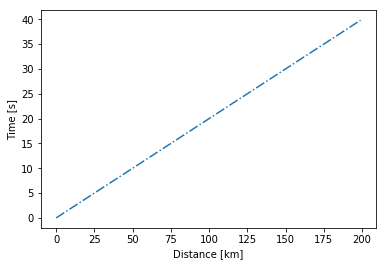

In [13]:
plt.plot(x, direct(x,v1),"-.")
plt.xlabel("Distance [km]")
plt.ylabel("Time [s]")

In [14]:
def reflected(x,v,h):
    return (2.*np.sqrt( (x/2)**2 + h**2 ))/v

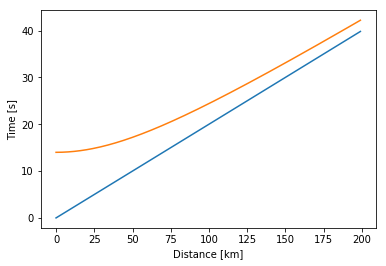

In [15]:
plt.plot(x, direct(x,v1))
plt.plot(x, reflected(x,v1,h))

plt.xlabel("Distance [km]")
plt.ylabel("Time [s]");

In [16]:
def refracted(x,v0,h,v1):
    p     = 1./v1              # Critical ray parameter
    theta = np.arcsin(p*v0)       # Critical angle
    minx  = 2*np.tan(theta)*h     # Critical Distance
    t = x/v1 + (2*h)*np.sqrt(1/v0**2-1/v1**2)
    t[x<minx] = None           # Remove times less than critical reflection
    return t

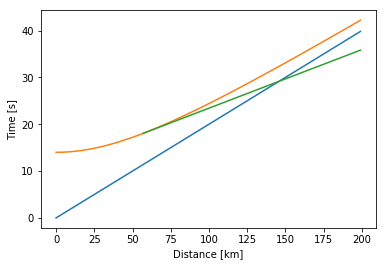

In [17]:
plt.plot(x, direct(x,v1))
plt.plot(x, reflected(x,v1,h))
plt.plot(x, refracted(x,v1,h,v2))
plt.xlabel("Distance [km]")
plt.ylabel("Time [s]");

In [18]:
def crustal_arrivals(x,v0,v1,h):
    x = np.arange(x*1.0)
    v0,v1,h = v0*1.0, v1*1.0, h*1.0
    td = direct(x,v0)
    tr = reflected(x,v0,h)
    th = refracted(x,v0,h,v1)
    plt.plot(x,td, label="Direct")
    plt.plot(x,tr, label="Reflected")
    plt.plot(x,th, label="Refracted")
    plt.legend(loc='upper left')
    plt.xlabel('Distance (km)')
    plt.ylabel('Time (s)')
    plt.xlim([0,max(x)])
    plt.ylim([0,50]);


In [19]:
from ipywidgets import *
interact(crustal_arrivals, x=fixed(300),v0=(4.0,7.5,0.5),v1=(7.5,12,0.5),h=(5,50,5));

interactive(children=(FloatSlider(value=5.5, description='v0', max=7.5, min=4.0, step=0.5), FloatSlider(value=…

### Travel times and Distances of Rays

Given that we now have a simple formula for the geometry of ray paths (Snell’s Law), if we have some distribution of known velocities, we can derive formulas for the distances $X (p, u)$ and times $T (p, u)$ for ray paths. Consider a segment $ds$ of a ray path:

We have:

\begin{align}
\sin \theta &= \dfrac{dx}{ds} \\
\cos \theta &= \dfrac{dz}{ds} = \sqrt{1-\sin^2\theta}
\end{align}

With that, let’s embark on formulizing the distance and time dependence of ray paths on ray parameter and slowness $u = \dfrac{1}{v}$.

## Distance

### Wanted
We want to get a derivative of $x$ with respect to $z$ so we can integrate through the wave speed model

Recall $p = u \sin \theta$. Thus

\begin{align}
\sin\theta &= \dfrac{p}{u} \\
\dfrac{dx}{ds}& = \dfrac{p}{u} \\
\dfrac{dz}{ds} &= \sqrt{1-\dfrac{p^2}{u^2}}
\end{align}

Rearrange

\begin{align}
&\sqrt{1-\dfrac{p^2}{u^2}}\\
&\sqrt{\dfrac{u^2}{u^2}\left(1-\dfrac{p^2}{u^2}\right)}\\
&\dfrac{\sqrt{u^2-p^2}}{p^2}
\end{align}

Employ our friend the chain rule:

$$
\dfrac{dx}{dz} = \dfrac{dx}{ds}\dfrac{ds}{dz} = \dfrac{\dfrac{dx}{ds}}{\dfrac{dz}{ds}} $$

Now plug in the quantities into the above:

$$
\dfrac{dx}{dz} = \dfrac{\dfrac{p}{u}}{\dfrac{\sqrt{u^2-p^2}}{p^2}}
=
\dfrac{p}{\sqrt{u^2-p^2}}
$$

Turn this into an integral:

$$
\int dx = \int \dfrac{p}{\sqrt{u^2-p^2}} dz
$$

$$
x(p) = p \int_{z_1}^{z_2} \dfrac{1}{\sqrt{u^2(z) - p^2}} dz
$$

We’re actually getting somewhere.  Integrate this thing from the free surface to the ray path’s turning depth ($z_p$) in the medium, that is:

$$
x(p) = p \int_{0}^{z_p} \dfrac{1}{\sqrt{u^2(z) - p^2}} dz
$$

For this case, since the ray path is symmetric about its turning point, the total distance $X(p) = 2 x(p)$:  

$$
X(p) = 2 p \int_{0}^{z_p} \dfrac{1}{\sqrt{u^2(z) - p^2}} dz
$$

If we had a functional form for $u(z) = \dfrac{1}{v(z)}$ , then we could solve this (or at least attempt it). Usually, as I mentioned above, we have a stack of layers to approximate gradients, etc.  You can recall the PREM model (from the famous Dziewonski and Anderson [1981] paper): it has a layered version of the whole Earth from crust through inner core.  

So we can write the $X(p)$ integral, instead, as a summation:

$$
X(p) = 2 p \sum_i \dfrac{1}{\sqrt{u_i^2 - p^2}} \Delta z_i
$$

Since we obviously want $\sqrt{u_i^2 - p^2}$ to be real, the above is only valid for $u_i > p$. Also, since $p = u_i \sin \theta_i$, the condition $p < u$ implies $\sin \theta_i< 1$, and hence $\theta_i < 90^\circ$. So we’re concerned with the part of the ray path right up to the turning point.  


In [20]:
def Xp(p,vi,zi):
    xp = 0
    for v,z in zip(vi,zi): # Iterate on two items at once
        u = 1./v
        if u > p : # If the sqrt in the bottom is "real"
            xp += z/sqrt(u**2 - p**2)
    return 2.0 * p * xp

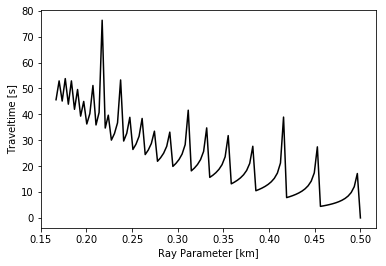

In [21]:
z = np.arange(0,21) # values from 0 to 20
v = 2. + z * 0.2    # Wave speed values
dz = np.diff(z)     # Layer Thicknesses
p = np.linspace(1/max(v),1/min(v),100) # Range of ray parameters
x = [Xp(pp,v,dz) for pp in p]  # Compute X(p) as above

# Plots
plt.plot(p,x,'k-')
plt.xlabel('Ray Parameter [km]')
plt.ylabel('Traveltime [s]');

## Travel time

Now we concern ourselves with travel time.  How long does it take a ray to travel $ds$ length? If the velocity is $v$, we have:

$$ v = \dfrac{ds}{dt} = \dfrac{1}{u} $$

Thus 

$$ \dfrac{dt}{ds} = u$$ 

Again, the Chain rule :

$$ \dfrac{dt}{dz} = \dfrac{dt}{ds} \dfrac{ds}{dz} = \dfrac{\dfrac{dt}{ds}}{\dfrac{dz}{sz}} $$

Or

$$ \dfrac{dt}{dz} = \dfrac{\dfrac{dt}{ds}}{\dfrac{dz}{sz}} = \dfrac{u}{\dfrac{\sqrt{u^2-p^2}}{u}} = \dfrac{u^2}{\sqrt{u^2-p^2}} $$

We can now write time as a function of ray parameter, for the same ray we considered for distance, above (i.e., from surface to turning point):

$$ t(p) = \int_{z_1}^{z_2} \dfrac{u^2(z)}{\sqrt{u^2(z)-p^2}} dz $$

And as with our distance calculation, the total travel time $T(p) = 2  t(p)$, or:

$$ T(p) = 2 \int_{0}^{z_p} \dfrac{u^2(z)}{\sqrt{u^2(z)-p^2}} dz $$

For a discretized stack of homogeneous layers, we can now write the travel time:

$$ T(p) = 2 \sum_{i} \dfrac{u_i^2}{\sqrt{u_i^2-p^2}} \Delta z_i $$

Let’s assume our velocity has the functional form of a linear gradient with depth, such as

$$ v(z) = a + b z $$

You can plug such functions into $X(p)$ or $T(p)$ to get distance or time predictions, respectively, in terms of your functional forms (if you solve the integral). 


In [22]:
def Tp(p,vi,zi):
    tp = 0
    for v,z in zip(vi,zi):
        u = 1./v
        if u > p :
            tp += u**2*z / sqrt(u**2 - p**2)
    return 2.0 * tp

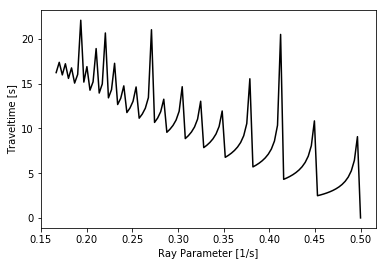

In [23]:
z = np.linspace(0,20,20)
v = 2. + z * 0.2
dz = np.diff(z)
p = np.linspace(1/max(v),1/min(v),100)
t = [Tp(pp,v,dz) for pp in p]
plt.figure()
plt.plot(p,t,'k-')
plt.ylabel('Traveltime [s]')
plt.xlabel('Ray Parameter [1/s]');

Text(0, 20, 'Yuck!')

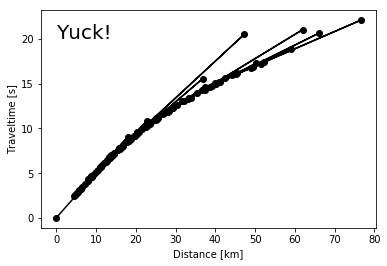

In [24]:
z = np.linspace(0,20,20)
v = 2. + z * 0.2
dz = np.diff(z)
p = np.linspace(1/max(v),1/min(v),100)
t = np.array([Tp(pp,v,dz) for pp in p])  # Compute T(p) as above
x = np.array([Xp(pp,v,dz) for pp in p])  # Compute X(p) as above
plt.figure()
plt.plot(x,t,'ko-')
plt.ylabel('Traveltime [s]')
plt.xlabel('Distance [km]');
plt.text(0, 20, "Yuck!", fontsize=20)

### $\tau(p)$ Curves

As we saw $t(x)$ is not always too well behaved:

$p(x)$ is better (smoother):

$x(p)$ is nicer (single-valued in the horizontal coordinate):

A common function called $\tau(p)$ is even better. This $\tau$ is not related to stress!  It is defined by the y-intercept of the  line tangent to the $t-x$  curve. 

From algebra, you’ll recall the equation of a line: 

$$y = m x + b$$. 

For us, and the above diagram, we have $T = p x + \tau$ .  Therefore, we can write:

$$\tau(p) = T(p) - p X(p) $$

We wrote capital $T$ and $X$, to correspond to our equations from above, for these entities versus ray parameter $p$, and slowness $u$.  Plug in definitions of $T$ and $X$, and we get:

\begin{align}
\tau(p) &= 2 \int_{0}^{z_p} \dfrac{u^2}{\sqrt{u^2-p^2}} - \dfrac{p^2}{\sqrt{u^2-p^2}} dz \\
&= 2 \int_{0}^{z_p} \sqrt{u^2-p^2} dz
\end{align}

And note: 

\begin{align}
\dfrac{d\tau}{dp} &= 2 \int_{0}^{z_p} \dfrac{1}{2}\dfrac{-2p}{\sqrt{u^2-p^2}} dz\\
&= 2p \int_{0}^{z_p} \dfrac{-p}{\sqrt{u^2-p^2}} dz\\
&= -X(p)
\end{align}

Thus, since $X \ge 0$ then $\dfrac{d\tau}{dp}$ is always $\le 0$.

In [25]:

def layert(p,h,utop,ubot):
    ''' 
LAYERXT calculates dx and dt for a ray in a layer with a linear
   velocity gradient.  This is a highly modified version of a
   subroutine in Chris Chapman’s WKBJ program.

 Inputs:   p     =  horizontal slowness
           h     =  layer thickness
           utop  =  slowness at top of layer
           ubot  =  slowness at bottom of layer
 Returns:  dx    =  range offset
           dt    =  travel time
           irtr  =  return code
                 = -1,  zero thickness layer
                 =  0,  ray turned above layer
                 =  1,  ray passed through layer
                 =  2,  ray turned in layer, 1 leg counted in dx,dt    
    '''
    if p >= utop:       # ray turned above layer
        return (0,0,0)
    elif h == 0:        # zero thickness layer
        return (0,0,-1)
    u1,u2=utop,ubot     # 
    v1,v2=1./u1, 1./u2  # Compute slownesses
    b=(v2-v1)/h         # slope of velocity gradient
    
    eta1=sqrt(u1**2-p**2) # Vertical Slowness

    if b == 0. :        # constant velocity layer
        dx = h * p / eta1
        dt = h * u1**2 / eta1
        return (dx,dt,1)
    
    x1 = eta1/(u1*b*p)  # Distance
    tau1=(log((u1+eta1)/p)-eta1/u1)/b # Intercept

    if p >= ubot :     # ray turned within layer,
        dx=x1          # no contribution to integral
        dtau=tau1      # from bottom point
        dt=dtau+p*dx
        return (dx,dt,2)

    eta2=sqrt(u2**2-p**2)  # Vertical Slowness
    x2=eta2/(u2*b*p)       # Distance
    tau2=(log((u2+eta2)/p)-eta2/u2)/b # Intercept
    dx=x1-x2               # Distance difference
    dtau=tau1-tau2         # Intercept difference
    dt=dtau+p*dx  # This is the equation from above
    return (dx,dt,1)

def xt(p,v,z):
    '''
Compute Distance, Time, Ray path in x and z
Inputs:
    - p - Ray Parameter
    - v - Wave Speed 
    - z - Depths of interfaces
    '''
    dz = np.diff(z)
    x,t = 0,0
    xr,zr = [],[]
    for i in range(len(dz)):
        # Compute dx and dt for ray parameter and layer thickness
        dx,dt,irtr = layert(p,dz[i],1./v[i],1./v[i+1])
        x += dx
        t += dt
        if irtr == 1: # Ray passed throught layer
            xr.append(dx)
            zr.append(dz[i])
        if irtr == 2: # Turning Ray
            xr.append(dx)
            # Determine the depth at which v = 1/p
            y = ( dz[i]/(v[i+1]-v[i]) ) * (1./p - v[i])
            zr.append(y)
            break
    xxr,zzr = [0],[0]
    for xi in xr:                  # Moving +x
        xxr.append(xxr[-1]+xi)
    for xi in xr[::-1]:            # Run through array backwards, moving +x
        xxr.append(xxr[-1]+xi)
    for zi in zr:                  # Going downwards
        zzr.append(zzr[-1]+zi)
    for zi in zr[::-1]:            # Run through array backwards, we are going upwards
        zzr.append(zzr[-1]-zi)
    return 2*x,2*t,np.array(xxr),np.array(zzr)

In [26]:
def vplot(v,z,p):
    xts = [xt(pp,v,z) for pp in p]
    xx,tt,xr,zr = zip(*xts) # Extract columns from single value
    plt.figure(figsize=(14,4))

    plt.subplot(1,4,1)
    plt.plot(v,z)
    plt.gca().invert_yaxis()
    plt.xlabel('Wave Speed [km/s]')
    plt.ylabel('Depth [km]')
    plt.title('Wave Speed model');
    
    plt.subplot(1,4,2),
    for k in range(len(xr)):
        plt.plot(xr[k],zr[k],'k');
    plt.xlabel('Distance [km]')
    plt.ylabel('Depth [km]')
    plt.title('Ray Paths');
    plt.ylim([0,20])
    plt.gca().invert_yaxis();
    
    plt.subplot(1,4,3)
    plt.plot(xx,tt)
    plt.xlabel('Distance [km]')
    plt.ylabel('Traveltime [s]')
    plt.title('Traveltime')
    plt.plot(xx,tt,'k.')

    plt.subplot(1,4,4)
    plt.plot(xx,p)
    plt.xlabel('Distance [km]')
    plt.ylabel('Ray Parameter [1/s]')
    plt.title('Ray Parameter');
    plt.plot(xx,p,'k.')

    
    plt.tight_layout()

## Simple Increasing Wave Speed (velocity) with depth

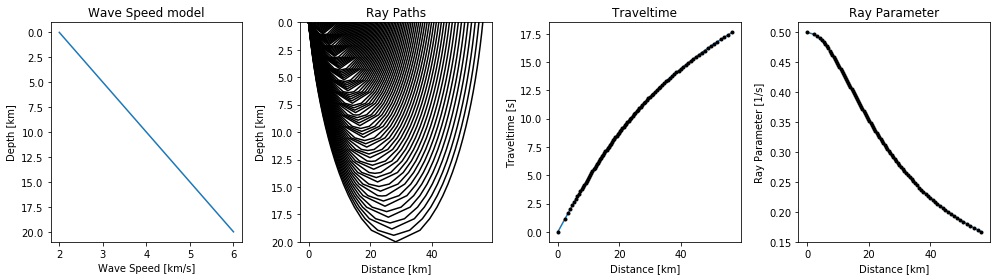

In [27]:
z = np.linspace(0,20,20)
v = 2. + z * 0.2
p = np.linspace(1/max(v),1/min(v),100)
vplot(v,z,p)

### Velocity Increase with Depth
In the ray parameter versus distance plot, we refer to prograde and retrograde behavior as $dx/dp < 0$ and $dx/dp > 0$, respectively.  Thus, as  we go from distance $A \rightarrow B$ and $C \rightarrow D$, we have prograde; as we go from $B \rightarrow C$ we have retrograde.  Caustics are the $dx/dp = 0$.

Many authors prefer to plot x versus p (e.g., Shearer), which looks like (for panel (d) above):


Panel (c), above, is a multi-valued travel time curve, as below.  This is called a “triplication”:

#### Reduced Time Plots
Note: a viewing convenience is often used to expand (in time) the triplication information. A transformation of the time-axis is frequently employed to reduce the slope of the information of interest.  Consider the following diagram:

### Velocity Decrease with Depth
In panel (a), the velocity-depth distribution displays a velocity reversal, with a zone of decreasing velocities.  Panel (b) depicts the ray paths due to this structure, which results in a distance range where no arrivals should occur, called the *shadow zone*. Panels (c) and (d) display possible travel time and ray parameter curves for such a structure.

Here’s another image, which more accurately represents a low velocity zone, from Kennett’s book:

## Low velocity zone (or shadow zone)

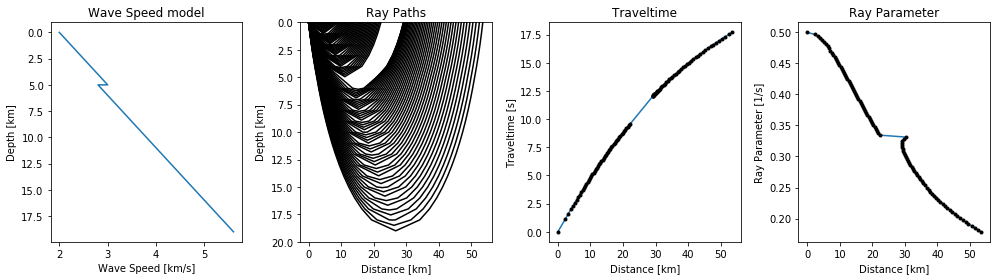

In [28]:
z,v = [],[]
for i in range(20):
    if i <= 5:
        z.append(i)
        v.append( 2.0 + i * 0.2 )
    if i >= 5:
        z.append(i)
        v.append( 1.8 + i * 0.2)

v, z = np.array(v), np.array(z)

p = np.linspace(1/max(v),1/min(v),100)
vplot(v,z,p)

## Velocity Increase with Depth (Discontinuity)

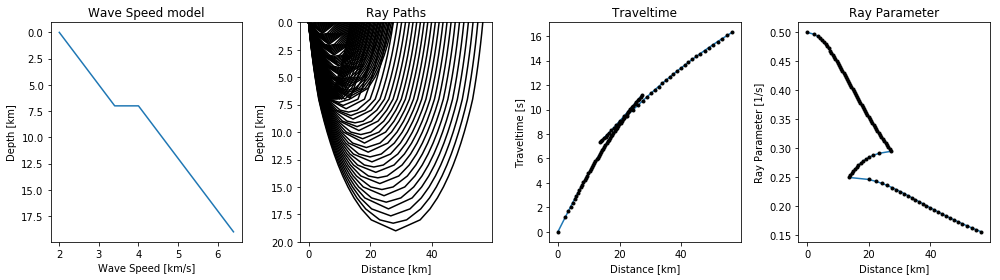

In [29]:
z,v = [],[]
for i in range(20):
    if i <= 7:
        z.append(i)
        v.append( 2.0 + i * 0.2 )
    if i >= 7:
        z.append(i)
        v.append( 2.6 + i * 0.2 )
v, z =np.array(v), np.array(z)

p = np.linspace(1/max(v),1/min(v),100)
vplot(v,z,p)